In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import os
import pandas as pd

from sodapy import Socrata

## GeoJSON Data

In [3]:
# Get shaply value from geojson
polygon = gpd.read_file('chelsea_network.geojson').to_crs(4326)['geometry'][0]

# Create graph from Open Street Map based on graph, Include travel time over edges
G = ox.add_edge_travel_times(ox.add_edge_speeds(ox.graph_from_polygon(polygon, network_type='drive', simplify=True)))

## The current method of just using osmnx to get the lines is not granular enough so we need to refilter the graph with gpd
# Creates dataframes based on nodes and edges
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# Remove edges outside of polygon
edges_gdf = edges_gdf[edges_gdf.geometry.within(polygon) == True]

## ATR Data

In [4]:
APP_TOKEN = os.getenv('APP_TOKEN')
client = Socrata('data.cityofnewyork.us', APP_TOKEN)
def request_atr_series(ids):
    endpoint = "7ym2-wayt"

    query = "SELECT COUNT(*)"

    NUM_RECORDS = int(client.get(endpoint, query=query)[0]['COUNT'])
    
    query = f"""
        SELECT *
        WHERE segmentid IN ({', '.join(map(str, ids))})
        AND yr = 2019
        LIMIT {NUM_RECORDS}
    """
    
    df = pd.DataFrame.from_records(client.get(endpoint, query=query))

    df['ts'] = pd.to_datetime(df[['yr', 'm', 'd', 'hh', 'mm']]\
                 .apply(lambda row: '-'.join(row), axis=1), format='%Y-%m-%d-%H-%M')
    df = df.astype({'vol':float})   
    
    
    gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df.wktgeom, crs="ESRI:102718")).drop(columns=['wktgeom'])
    gdf = gdf.to_crs(4326)
    
    gdf['segment_direction'] = df.segmentid + '-' + df.direction
    
    return gdf

atrs_gdf = request_atr_series([32462, 32285,
                         32467, 32814,
                         32811, 32798, 32795,
                         32628, 32634, 32632,
                         32460, 32458, 271225,
                         32299, 32301, 32463])

In [5]:
# match our ATR data (df) to the closest street segment in the OSMNX graph (gdf_edges)
atrs_with_streets_gdf = atrs_gdf.to_crs(3857).sjoin_nearest(edges_gdf.reset_index().to_crs(3857), distance_col='dist', how='inner').drop(columns=['index_right']).to_crs(4326).rename(columns={'geometry':'atr_geometry'}).set_geometry('atr_geometry')

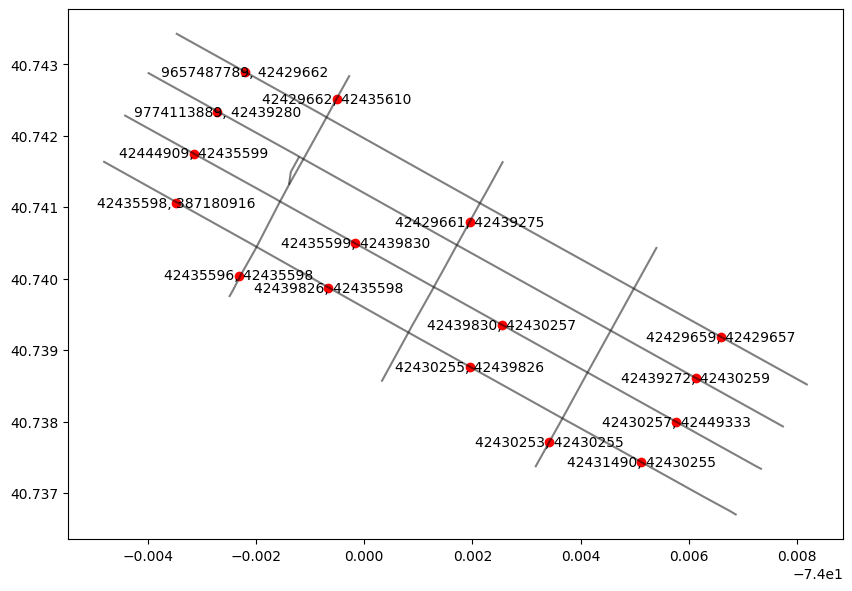

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
edges_gdf.plot(ax=ax, color='black', alpha=0.5)
unique_atr_gdf = atrs_with_streets_gdf.dissolve(by=['u','v','key'], as_index=False)
unique_atr_gdf.plot(ax=ax, color='red')

for idx, row in unique_atr_gdf.iterrows():
    plt.annotate(text= str(row['u']) + ', ' + str(row['v']), xy=row['atr_geometry'].coords[0], horizontalalignment='center', verticalalignment='center')

In [7]:
inbound_atrs_lst = {'14st_8av':('42435596','42435598'), '16st_8av':('42444909','42435599'), '18st_8av':('9657487789','42429662'), '14st_6av':('42430253','42430255'), '15st_6av':('42431490','42430255'), '17st_6av':('42439272','42430259'),'19st_7av': (None,None)}
outbound_atrs_lst = {'15st_8av':('42435598','387180916'),'17st_8av':('9774113889','42439280'), '19st_8av':('42429662','42435610'),'18st_6av':('42429659','42429657'),'16st_6av':('42430257','42449333'),'14st_7av':(None,None), '19st_6av':(None,None)}

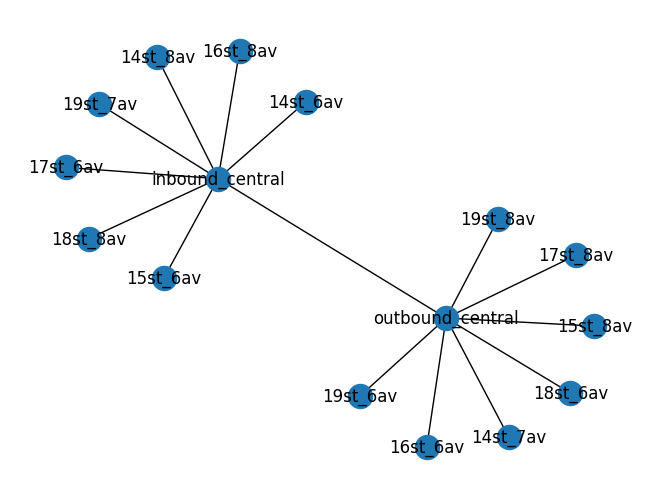

In [20]:
G = nx.Graph()

G.add_nodes_from(inbound_atrs_lst.keys())

G.add_nodes_from(outbound_atrs_lst.keys())

G.add_nodes_from(['inbound_central','outbound_central'])


for node in inbound_atrs_lst.keys():
    G.add_edge(node, 'inbound_central')

G.add_edge('inbound_central', 'outbound_central')

for node in outbound_atrs_lst.keys():
    G.add_edge('outbound_central', node)

nx.draw(G, with_labels=True)

## CVXPY
Minimize $$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2 + \lambda_1||\bar{F}L'F||_F + \lambda_2||FL'\bar{F}||_F + \lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F + \lambda_5||\bar{F} - F||_F$$
s.t.
1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [26]:
atrs_with_streets_gdf['ts']

0       2019-10-18 17:00:00
1       2019-10-18 17:15:00
2       2019-10-18 17:30:00
3       2019-10-18 17:45:00
5       2019-10-18 18:00:00
                ...        
17761   2019-10-31 01:30:00
17765   2019-10-31 01:45:00
17770   2019-10-31 02:00:00
17772   2019-10-31 02:15:00
17776   2019-10-31 02:30:00
Name: ts, Length: 17790, dtype: datetime64[ns]

In [28]:
atrs_with_streets_gdf.columns

Index(['requestid', 'boro', 'yr', 'm', 'd', 'hh', 'mm', 'vol', 'segmentid',
       'street', 'fromst', 'tost', 'direction', 'ts', 'atr_geometry',
       'segment_direction', 'u', 'v', 'key', 'osmid', 'oneway', 'lanes',
       'name', 'highway', 'maxspeed', 'reversed', 'length', 'speed_kph',
       'travel_time', 'dist'],
      dtype='object')

In [31]:
flow_df = atrs_with_streets_gdf[['vol','ts','u','v','key']]

In [40]:
flow_df['u']

0        42444909
1        42444909
2        42444909
3        42444909
5        42444909
           ...   
17761    42435596
17765    42435596
17770    42435596
17772    42435596
17776    42435596
Name: u, Length: 17790, dtype: int64

In [44]:
flow_df[flow_df['u'].astype(str).isin([x[0] for x in inbound_atrs_lst.values()])]

,vol,ts,u,v,key
0,0.0,2019-10-18 17:00:00,42444909,42435599,0
1,58.0,2019-10-18 17:15:00,42444909,42435599,0
2,72.0,2019-10-18 17:30:00,42444909,42435599,0
3,73.0,2019-10-18 17:45:00,42444909,42435599,0
5,79.0,2019-10-18 18:00:00,42444909,42435599,0
...,...,...,...,...,...
17761,40.0,2019-10-31 01:30:00,42435596,42435598,0
17765,25.0,2019-10-31 01:45:00,42435596,42435598,0
17770,32.0,2019-10-31 02:00:00,42435596,42435598,0
17772,34.0,2019-10-31 02:15:00,42435596,42435598,0
